<a href="https://colab.research.google.com/github/chenab0/amath481_chenab1/blob/main/hw5_02_481.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags

L = 20
m = 64   # N value in x and y directions
n = m * m  # total size of matrix
dx = L/m


e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0  # overwrite every m^th value with zero
    e4[m*j-1] = 1  # overwirte every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]


# Place diagonal elements
diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
             e2.flatten(), -4 * e1.flatten(), e3.flatten(),
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

matA = spdiags(diagonals, offsets, n, n).toarray()/dx**2
matA[1, 1] = 2 / dx**2
diagonals = [e1.flatten(), -1 * e1.flatten(), e1.flatten(),-1 * e1.flatten()]
offsets = [-(n-m), -m, m, (n-m)]

matB = spdiags(diagonals, offsets, n, n)/(2*dx)


diagonals = [e5.flatten(), -1 * e2.flatten(), e3.flatten(), -1 * e4.flatten()]
offsets = [-(m-1), -1, 1, (m-1)]

matC = spdiags(diagonals, offsets, n, n)/(2*dx)



A1 = matA
A2 = matB
A3 = matC



0.3125


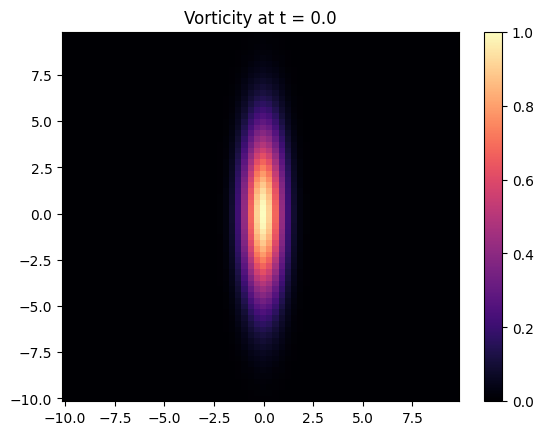

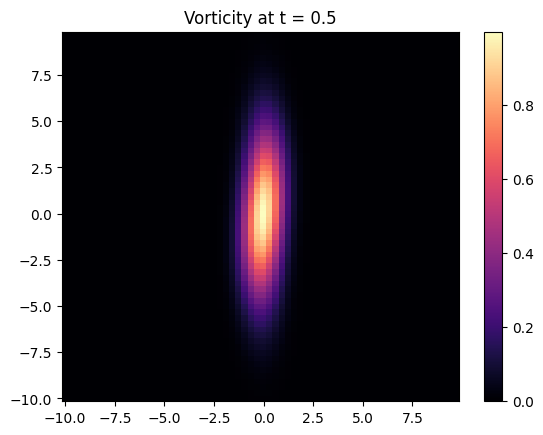

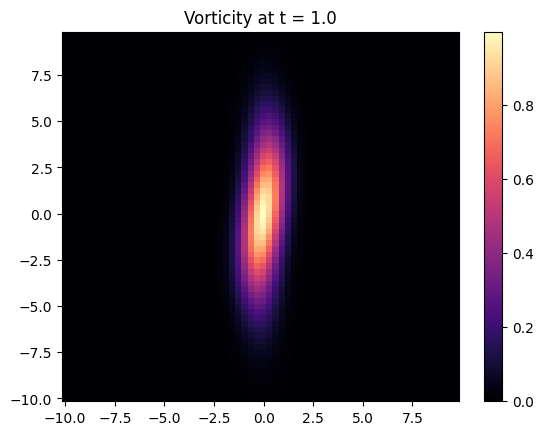

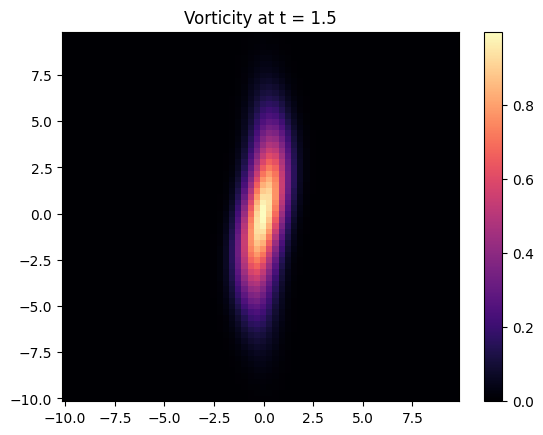

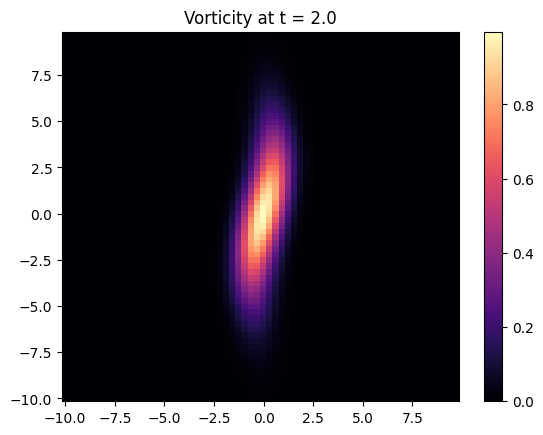

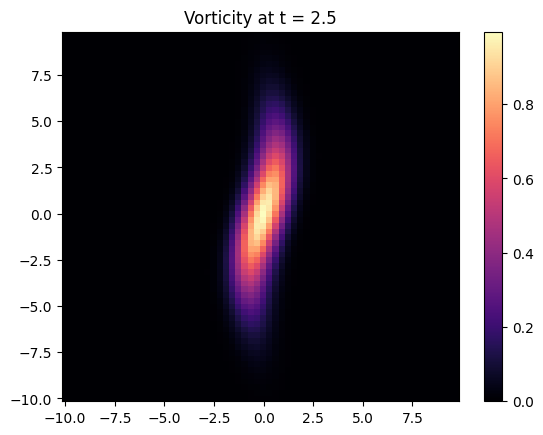

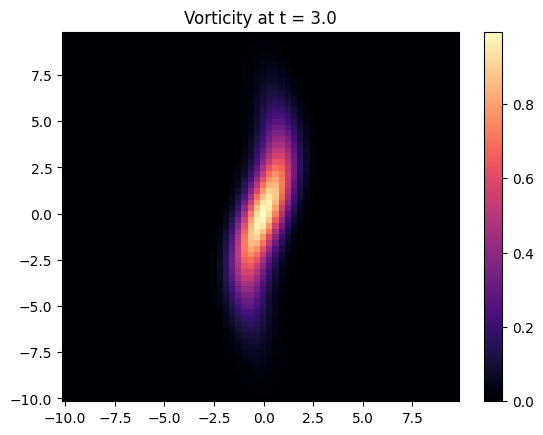

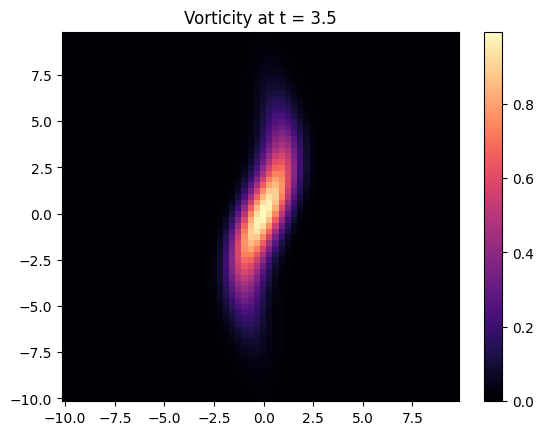

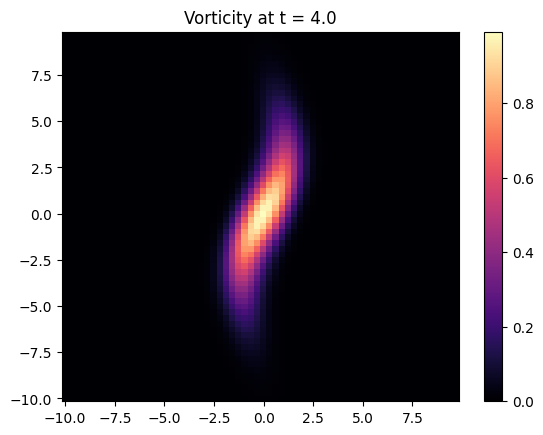

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
import os
import imageio.v2 as imageio
import scipy
import scipy.linalg
from scipy.sparse.linalg import spsolve

tspan = np.arange(0, 4.5, 0.5)
tp = (tspan[0], tspan[-1])

# Parameters
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Create grid
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
dx = x[1] - x[0]
print(dx)
X, Y = np.meshgrid(x, y)

w0 = 1 * np.exp(-X**2 - (1/20)*Y**2)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2




def spc_rhs(t, w_flat):
    w = w_flat.reshape((nx, ny))
    w_cap = fft2(w)
    psi_cap = -w_cap / K
    psi = ifft2(psi_cap).real
    psi_flat = psi.flatten()


    psi_x_flat = matB @ psi_flat
    psi_y_flat = matC @ psi_flat
    w_x_flat = matB @ w_flat
    w_y_flat = matC @ w_flat

    jacobian_flat = psi_x_flat * w_y_flat - psi_y_flat * w_x_flat
    laplacian_w_flat = matA @ w_flat

    w_t_flat = -jacobian_flat + nu * laplacian_w_flat

    return w_t_flat

def AB_rhs(t, w_flat):
    psi_flat = spsolve(matA, w_flat)
    psi_x_flat = matB @ psi_flat
    psi_y_flat = matC @ psi_flat
    w_x_flat = matB @ w_flat
    w_y_flat = matC @ w_flat

    jacobian_flat = psi_x_flat * w_y_flat - psi_y_flat * w_x_flat
    laplacian_w_flat = matA @ w_flat

    w_t_flat = -jacobian_flat + nu * laplacian_w_flat

    return w_t_flat

def LU_rhs(t, w_flat):
    P, L, U = scipy.linalg.lu(matA)
    b2 = np.matmul(P, w_flat)
    y = np.linalg.solve(L,b2)
    psi_flat = np.linalg.solve(U,y)

    psi_x_flat = matB @ psi_flat
    psi_y_flat = matC @ psi_flat
    w_x_flat = matB @ w_flat
    w_y_flat = matC @ w_flat

    jacobian_flat = psi_x_flat * w_y_flat - psi_y_flat * w_x_flat
    laplacian_w_flat = matA @ w_flat

    w_t_flat = -jacobian_flat + nu * laplacian_w_flat

    return w_t_flat


w0_flat = w0.reshape(N)
sol = solve_ivp(spc_rhs, tp, w0_flat, t_eval = tspan, args=(), method='RK45')

w_sol = sol.y
ts = sol.t
A1 = w_sol  # Each column corresponds to omega at a time in t_eval
A1 = A1.T


for j, t in enumerate(tspan):
    omega = A1[j].reshape((nx, ny))
    fig, ax = plt.subplots()
    im = ax.pcolor(x, y, omega, shading = 'auto', cmap='magma')
    fig.colorbar(im)
    ax.set_title(f'Vorticity at t = {t:.1f}')
    plt.show()



<ipython-input-20-11490b57d7ec>:63: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  psi_flat = spsolve(matA, w_flat)


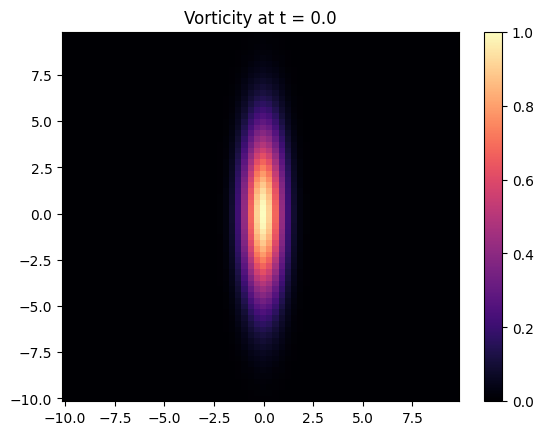

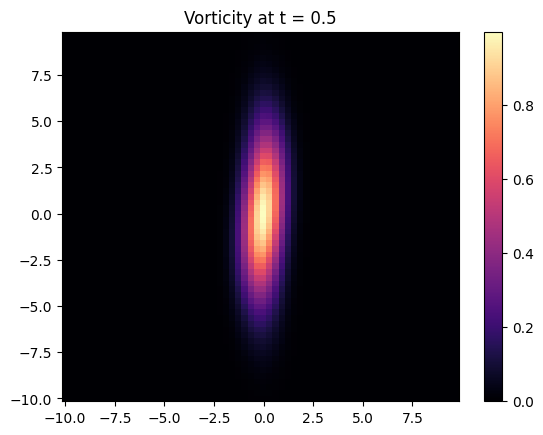

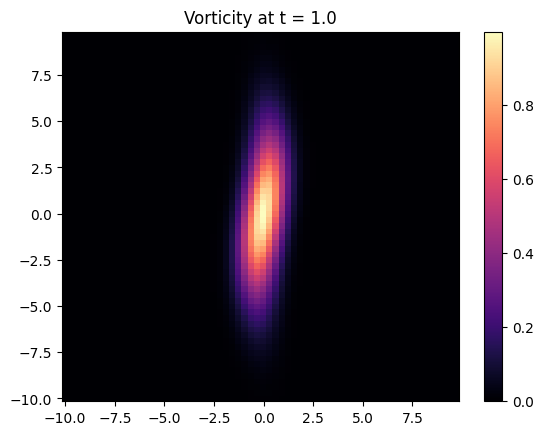

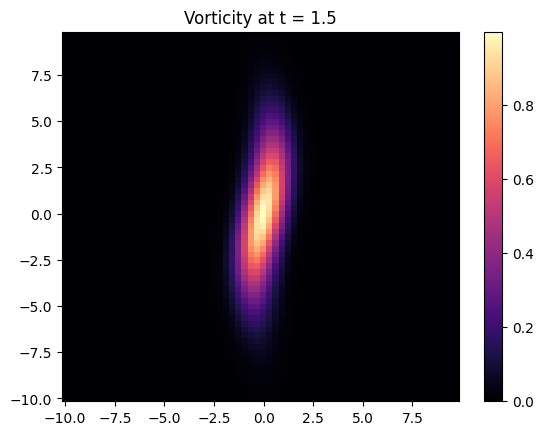

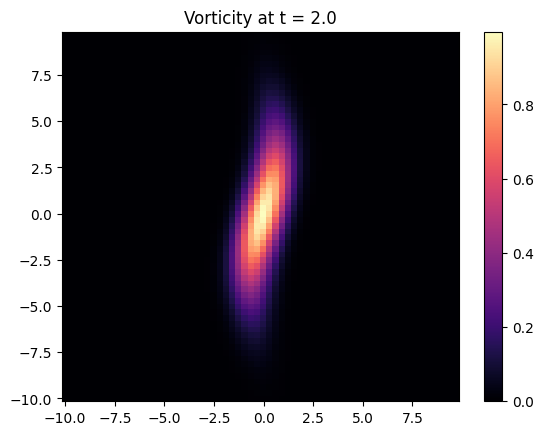

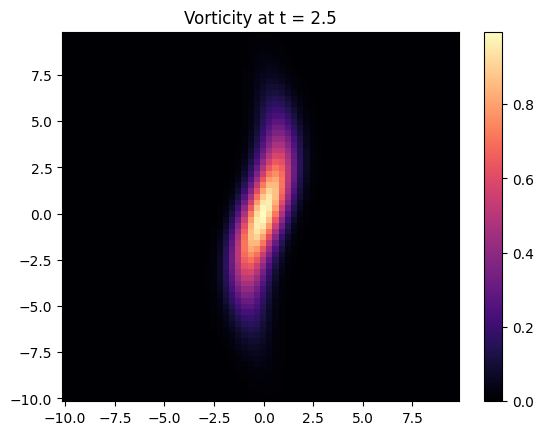

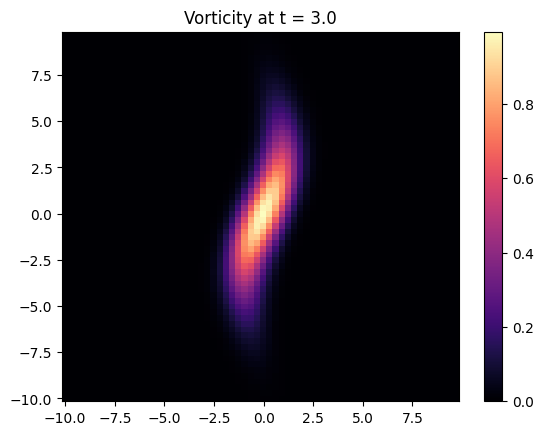

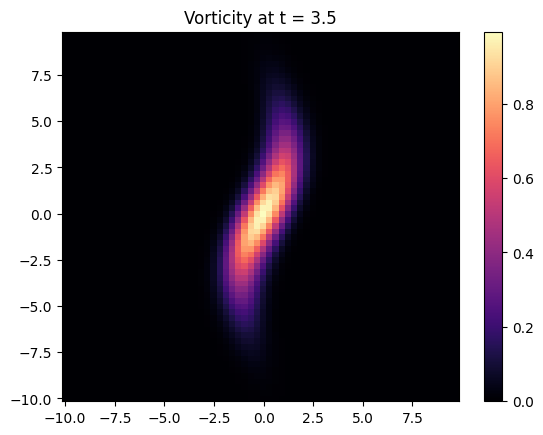

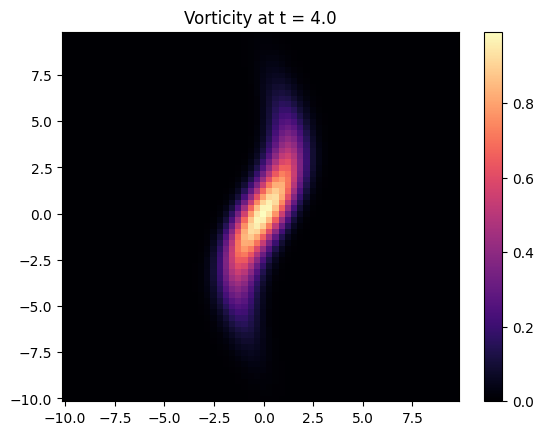

In [ ]:
sol = solve_ivp(AB_rhs, tp, w0_flat, t_eval = tspan, args=(), method='RK45')

w_sol = sol.y
ts = sol.t
A2 = w_sol  # Each column corresponds to omega at a time in t_eval
A2 = A2.T


for j, t in enumerate(tspan):
    omega = A2[j].reshape((nx, ny))
    fig, ax = plt.subplots()
    im = ax.pcolor(x, y, omega, shading = 'auto', cmap='magma')
    fig.colorbar(im)
    ax.set_title(f'Vorticity at t = {t:.1f}')
    plt.show()

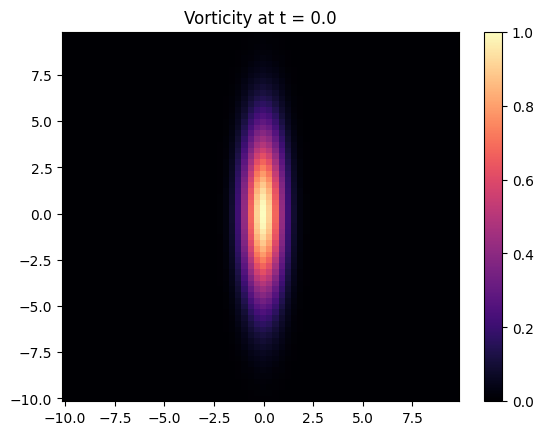

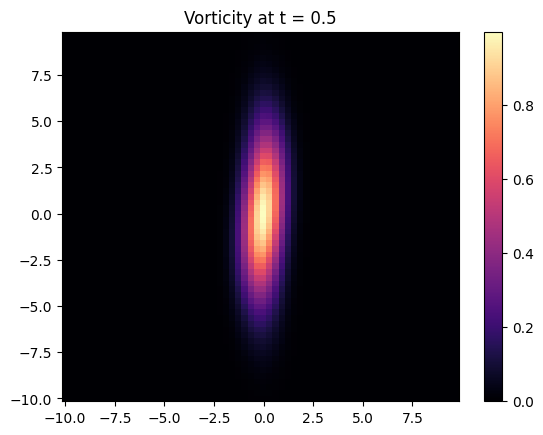

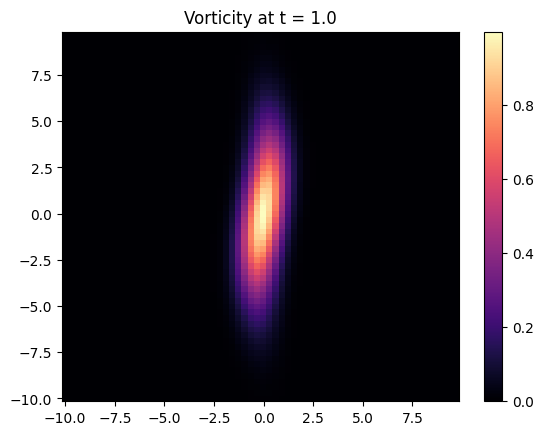

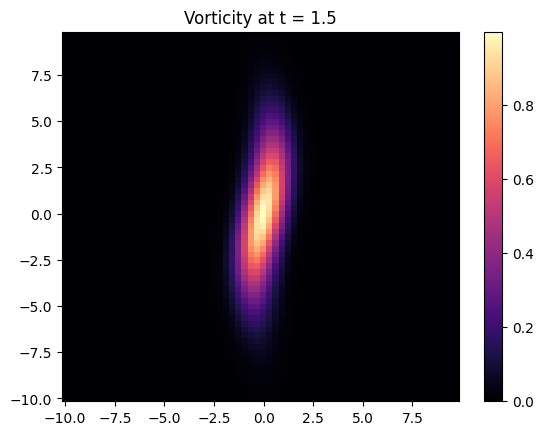

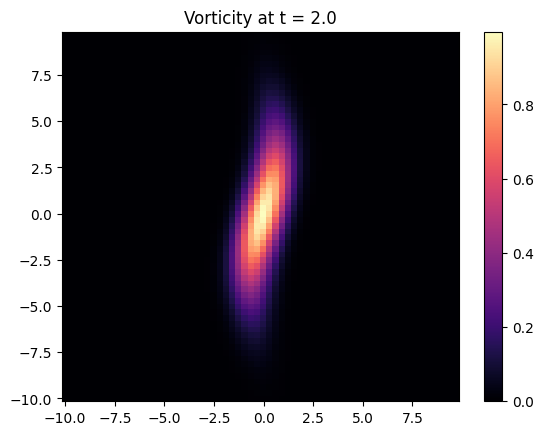

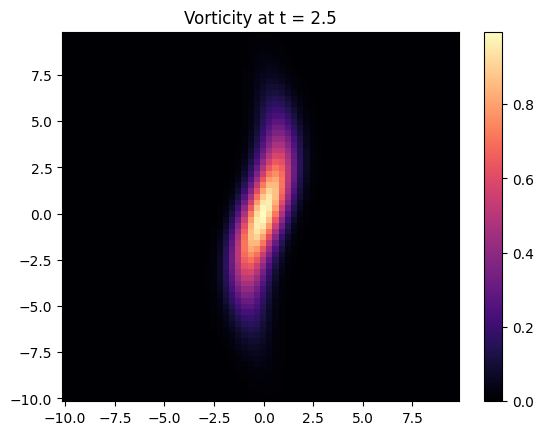

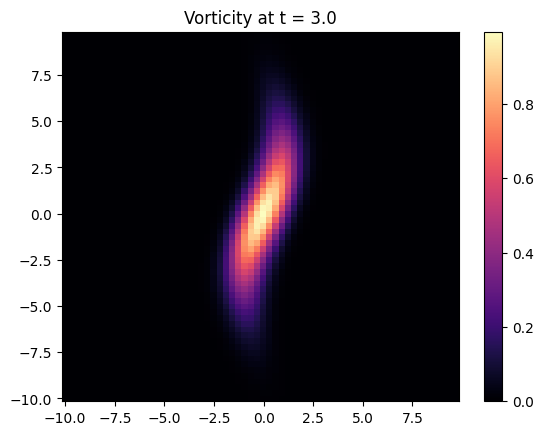

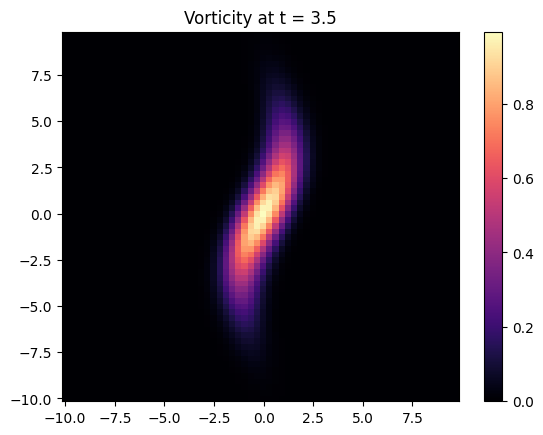

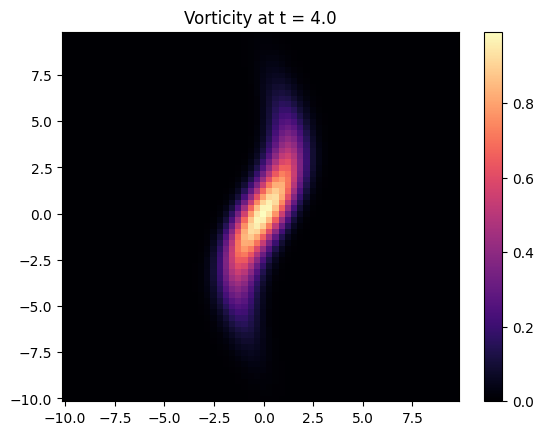

In [ ]:
sol = solve_ivp(LU_rhs, tp, w0_flat, t_eval = tspan, args=(), method='RK45')

w_sol = sol.y
ts = sol.t
A3 = w_sol  # Each column corresponds to omega at a time in t_eval
A3 = A3.T


for j, t in enumerate(tspan):
    omega = A3[j].reshape((nx, ny))
    fig, ax = plt.subplots()
    im = ax.pcolor(x, y, omega, shading = 'auto', cmap='magma')
    fig.colorbar(im)
    ax.set_title(f'Vorticity at t = {t:.1f}')
    plt.show()